<a href="https://colab.research.google.com/github/RiceWater/New-Thesis-KFold-3CLS/blob/No-Building/Kaggle_3CLS_No_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [2]:
!pip uninstall jax -y

Found existing installation: jax 0.4.26
Uninstalling jax-0.4.26:
  Successfully uninstalled jax-0.4.26


In [3]:
!pip install tensorflow==2.15.0

In [4]:
!python --version

Python 3.10.12


In [5]:
!pip install image_to_numpy==1.0.0

  Preparing metadata (setup.py) ... done
  Created wheel for image_to_numpy: filename=image_to_numpy-1.0.0-py3-none-any.whl size=3456 sha256=dd3e709ea34a1f603be03a6027910411963ac282a2d145ce1da2ac963c3cddcf
  Stored in directory: /root/.cache/pip/wheels/4c/e5/7e/f10f47129bb75abc8cd52a8abbff926b4a6121990f926cfe6d
Successfully built image_to_numpy


In [6]:
!pip install neptune==1.9.1 neptune-tensorflow-keras==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.5/495.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.5 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67672 sha256=4658db28348354868d0351b7b99c15df088af0184b513ec51e43e4a3e068aa7c
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44e

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

In [9]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset'):
    print(os.path.join(dirname))




/content/drive/MyDrive/Chua_Thesis/4-600-Dataset
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Road
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Vehicle
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Plant
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Building


In [10]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))

    model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=384,activation="relu"))
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=256,activation="relu"))

    model.add(Dense(units=3, activation="softmax"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )

    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
def create_callbacks(counter):
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + str(counter),
                                                                 monitor='val_loss',
                                                                 mode='auto',
                                                                 save_best_only=True,
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=23,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                         factor=0.6,
                                                         patience=15,
                                                         min_delta=0.001,
                                                         mode='auto',
                                                         verbose=1)
#     return [reduce_lr, cp_callback, es_callback]
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [12]:
def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

In [13]:
with tf.device('/gpu:0'):
    labels = ['Plant', 'Vehicle', 'Road']
    X_train = []
    y_train = []
    y_label_idx = []
    image_size = 256
    for i in labels:
        folderPath = os.path.join('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset', i)
        for j in os.listdir(folderPath):
            img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_train.append(img)
            y_label_idx.append(labels.index(i))

In [14]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [15]:
# seed ensures that the generation are the same from local and kaggle
rng = default_rng(seed=1)

plants_test_idx = rng.choice(np.arange(0,600), size=120, replace=False)
vehicles_test_idx = rng.choice(np.arange(600,1200), size=120, replace=False)
roads_test_idx = rng.choice(np.arange(1200,1800), size=120, replace=False)
total_test_idx = np.concatenate((plants_test_idx, vehicles_test_idx, roads_test_idx), axis=None)
print(total_test_idx[:20])

[273 397 467 471 105 584 208 456  32 573 462 540 261 134 460 229 494 293
 412 515]


In [16]:
def train_test_X(X_train_scaled):
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [17]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

## KFOLD

In [ ]:
!mkdir MODEL

In [ ]:
!ls ./

In [ ]:
model_name= 'Model 3CLS-NB-4.1.3'
checkpoint_path = f'/content/MODEL/{model_name}/FOLD-'
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)
project_name='New-Thesis/Kaggle-3Cls-No-Building'

In [ ]:
params = {
    "lr": 0.001,
    "epochs": 55,
    "batch_size": 8}

precisions = []
recalls = []
accuracies = []
f1_plant = []
f1_road = []
f1_vcl = []

with tf.device('/gpu:0'):
    counter = 0
    start = perf_counter()
    for train, test in kfold.split(train_x, train_y):
        start_fold = perf_counter()

        run = neptune.init_run(
            name= f"{model_name}-FOLD_{counter}",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )  # your credentials

        run["parameters"] = params


        model = make_model(params)
        cat_y = tf.keras.utils.to_categorical(train_y)

        train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], cat_y[train]))
        train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])

        test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], cat_y[test]))
        test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])

        hist = model.fit(train_fold,
                         validation_data=test_fold,
                         batch_size=params['batch_size'],
                         epochs=params['epochs'],
                         verbose=1,
                         callbacks=create_callbacks(counter))
        end_fold = perf_counter()

        # PLOTTING ==================================================
        run["fig-train_loss"].upload(plot_loss(hist))
        run["fig-train_acc"].upload(plot_acc(hist))

        # EVALUATING ==================================================
        model = tf.keras.models.load_model(checkpoint_path + str(counter))

        pre = Precision()
        rec = Recall()
        c_acc = CategoricalAccuracy()
        f1_score = F1Score()
        for batch in test_fold.as_numpy_iterator():
            X, y = batch
            yhat = model.predict(X, verbose=0)
            pre.update_state(y, yhat)
            rec.update_state(y, yhat)
            c_acc.update_state(y, yhat)
            f1_score.update_state(y, yhat)


        precisions.append(pre.result().numpy() * 100)
        recalls.append(rec.result().numpy() * 100)
        accuracies.append(c_acc.result().numpy() * 100)
        f1_s = f1_score.result().numpy() * 100

        f1_plant.append(f1_s[0])
        f1_vcl.append(f1_s[1])
        f1_road.append(f1_s[2])

        run["eval/ACC/"] = accuracies[counter]
        run["eval/REC/"] = recalls[counter]
        run["eval/PRE/"] = precisions[counter]
        run["eval/F1-P"] = f1_plant[counter]
        run["eval/F1-R"] = f1_road[counter]
        run["eval/F1-V"] = f1_vcl[counter]

        # SAVE MODEL TO NEPTUNE AI =======================================
        model_save_path = f'{checkpoint_path}{counter}/{model_name}-FOLD-{counter}.keras'
        model.save(model_save_path)
        run['checkpoint/model'].upload(model_save_path)

        # PRINTING RESULTS ===========================================
        print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
        print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
        print(f'Accuracy: {accuracies[counter]}')
        print(f'F1Score-P: {f1_plant[counter]}')
        print(f'F1Score-R: {f1_road[counter]}')
        print(f'F1Score-V: {f1_vcl[counter]}')

        run.stop()

        counter += 1

    end = perf_counter()
    print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

In [ ]:
print(f"""
Avg Accuracy: {avg_rate(accuracies)}
Avg Precision: {avg_rate(precisions)}
Avg Recall: {avg_rate(recalls)}
Avg F1-Score-P: {avg_rate(f1_plant)}
Avg F1-Score-R: {avg_rate(f1_road)}
Avg F1-Score-V: {avg_rate(f1_vcl)}
""")

In [ ]:
run = neptune.init_run(
            name= f"{model_name}-AVG",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )

run["eval/PRE/"] = avg_rate(precisions)
run["eval/REC/"] = avg_rate(recalls)
run["eval/ACC/"] = avg_rate(accuracies)
run["eval/F1-P"] = avg_rate(f1_plant)
run["eval/F1-R"] = avg_rate(f1_road)
run["eval/F1-V"] = avg_rate(f1_vcl)

run.stop()

In [ ]:
os.environ['NEPTUNE_API_TOKEN'] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiM2YzNGEwOC1iNmYyLTQ3YTEtYTljNi0xOWNmYWE0ZjZjOTMifQ=="

In [ ]:
!neptune sync -p 'New-Thesis/Kaggle-3Cls-No-Building' --offline-only


In [ ]:
!neptune clear


In [ ]:
!rm -r "/content/MODEL/Model 3CLS-NB-4.1.3"

In [ ]:
##

## TRAIN Final Model

In [18]:
def make_model_final(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))

    model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=128,activation="relu"))
    model.add(Dense(units=64,activation="relu"))

    model.add(Dense(units=3, activation="softmax"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )

    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
def create_callbacks_final():
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=final_checkpoint_path,
                                                                 monitor='val_loss',
                                                                 mode='auto',
                                                                 save_best_only=True,
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=15,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                         factor=0.6,
                                                         patience=5,
                                                         min_delta=0.001,
                                                         mode='auto',
                                                         verbose=1)
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [20]:
def plot_loss_final(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

def plot_acc_final(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

In [21]:
final_model = "Final-3CLS-NB-4_0_1"
final_checkpoint_path = f'./checkpoints/{final_model}/'
params = {
    "lr": 0.001,
    "epochs": 55,
    "batch_size": 8}
project_name='New-Thesis/Kaggle-3Cls-No-Building'

In [22]:
train_y_final = tf.keras.utils.to_categorical(train_y)
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y_final))
compiled_train_dataset  = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])

holdout_y_final = tf.keras.utils.to_categorical(holdout_y)
test_dataset = tf.data.Dataset.from_tensor_slices((holdout_x, holdout_y_final))
holdout_test_dataset = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])


In [23]:
run = neptune.init_run(
        name= f"{final_model}",
        project=project_name,
        mode="offline"     # To prevent issue when internet sucks. Just manually sync it
    )  # your credentials

run["parameters"] = params
model = make_model_final(params)

[neptune] [info   ] Neptune initialized. Open in the app: offline/346a3291-287f-493d-bf26-567b4a82fa49


[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


In [24]:
start = perf_counter()
hist = model.fit(compiled_train_dataset,
                 validation_data=holdout_test_dataset,
                 batch_size=params['batch_size'],
                 epochs=params['epochs'],
                 verbose=1,
                 callbacks=create_callbacks_final())
end = perf_counter()



Epoch 1/55
179/180 [============================>.] - ETA: 0s - loss: 1.8880 - accuracy: 0.7472
Epoch 1: val_loss improved from inf to 3.89070, saving model to ./checkpoints/Final-3CLS-NB-4_0_1/
180/180 [==============================] - 15s 39ms/step - loss: 1.8775 - accuracy: 0.7486 - val_loss: 3.8907 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/55
180/180 [==============================] - ETA: 0s - loss: 0.4900 - accuracy: 0.8674
Epoch 2: val_loss improved from 3.89070 to 1.36588, saving model to ./checkpoints/Final-3CLS-NB-4_0_1/
180/180 [==============================] - 5s 26ms/step - loss: 0.4900 - accuracy: 0.8674 - val_loss: 1.3659 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 3/55
179/180 [============================>.] - ETA: 0s - loss: 0.3421 - accuracy: 0.8925
Epoch 3: val_loss improved from 1.36588 to 0.21689, saving model to ./checkpoints/Final-3CLS-NB-4_0_1/
180/180 [==============================] - 4s 25ms/step - loss: 0.3410 - accuracy: 0.8924 - val_loss: 0.2169 - val_a

In [25]:
# EVALUATING ==================================================
model = tf.keras.models.load_model(final_checkpoint_path)

pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()
f1_score = F1Score()
for batch in holdout_test_dataset.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X, verbose=0)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)
    f1_score.update_state(y, yhat)

precision = pre.result().numpy() * 100
recall = rec.result().numpy() * 100
accuracy = c_acc.result().numpy() * 100
f1_s = f1_score.result().numpy() * 100

f1_p = f1_s[0]
f1_v = f1_s[1]
f1_r = f1_s[2]

run["eval/ACC/"] = accuracy
run["eval/REC/"] = recall
run["eval/PRE/"] = precision
run["eval/F1-P"] = f1_p
run["eval/F1-V"] = f1_v
run["eval/F1-R"] = f1_r


# SAVE MODEL TO NEPTUNE AI =======================================
model_save_path = f'./{final_model}.keras'
model.save(model_save_path)
run['checkpoint/model'].upload(model_save_path)

# PRINTING RESULTS ===========================================
print(f'Fold Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')
print(f'Precision: {precision}  -  Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'F1Score-P: {f1_p}')
print(f'F1Score-V: {f1_v}')
print(f'F1Score-R: {f1_r}')

Fold Training Time: 0 hour(s) and 2 mins
Precision: 96.94444537162781  -  Recall: 96.94444537162781
Accuracy: 96.94444537162781
F1Score-P: 95.83332824707031
F1Score-V: 97.5
F1Score-R: 97.5


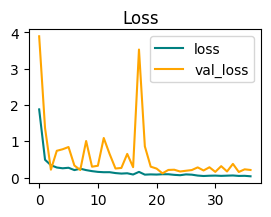

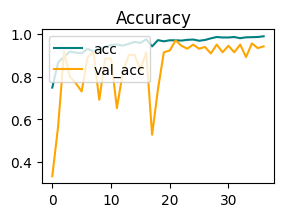

In [26]:
run["fig-train_loss"].upload(plot_loss(hist))
run["fig-train_acc"].upload(plot_acc(hist))

In [27]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


In [28]:
model.save_weights(f"./weights/{final_model}")

In [29]:
!zip -r Final-3CLS-NB-4_0_1.zip ./weights

  adding: weights/ (stored 0%)
  adding: weights/Final-3CLS-NB-4_0_1.data-00000-of-00001 (deflated 7%)
  adding: weights/checkpoint (deflated 40%)
  adding: weights/Final-3CLS-NB-4_0_1.index (deflated 61%)


In [30]:
os.environ['NEPTUNE_API_TOKEN'] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiM2YzNGEwOC1iNmYyLTQ3YTEtYTljNi0xOWNmYWE0ZjZjOTMifQ=="

In [31]:
!neptune sync -p 'New-Thesis/Kaggle-3Cls-No-Building' --offline-only

Offline container 9bd80c0b-6524-46ec-9451-377c46f53894 registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-44
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-44
Deleted: /content/.neptune/async/run__9bd80c0b-6524-46ec-9451-377c46f53894__11344__fqqlvrxo
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-44 completed.


## Extract Model Checkpoint
- Download model from neptune AI
- Upload here
- change path and names and run code

In [ ]:
sm = tf.keras.models.load_model("/content/model.keras")


In [ ]:
FIX-MODEL-NAME

sm.save_weights("./checkpoints/test_model")


In [ ]:
!zip -r test.zip "./checkpoints"